この問題は、  
 - 「過去のデータを使って完全に未知なる問題を解け」  

という問題。

In [1]:
import os
os.chdir('../py')

import pandas as pd
import numpy as np
import feather

from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'Ricty Diminised'
sns.set(style="whitegrid", font='Ricty Diminised', palette="muted", color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

import japanize_matplotlib

from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder

# my modules
import EDA
import utils

from scipy.stats import ks_2samp

In [2]:
train = feather.read_dataframe('../input/feather/train.ftr')

test = feather.read_dataframe('../input/feather/test.ftr')

In [3]:
numeric_feature = train.columns[train.dtypes != 'object']

numeric_feature = [col for col in list(numeric_feature) if col not in ['TransactionID', 'isFraud', 'TransactionDT']]

In [6]:
import datetime

In [9]:
def datetime_converter(df):
    START_DATE = '2017-12-01'
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')    
    df = df.assign(
            # New feature - decimal part of the transaction amount
            TransactionAmt_decimal = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int),

            # Count encoding for card1 feature. 
            # Explained in this kernel: https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
            card1_count_full = df['card1'].map(df['card1'].value_counts(dropna=False)),

            # https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
            Transaction_day_of_week = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7),
            Transaction_hour = np.floor(df['TransactionDT'] / 3600) % 24,

            TransactionDT = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x))),
        )
    df = df.assign(
            # Time of Day
            year = df['TransactionDT'].dt.year,
            month = df['TransactionDT'].dt.month,
            dow = df['TransactionDT'].dt.dayofweek,
            quarter = df['TransactionDT'].dt.quarter,
            hour = df['TransactionDT'].dt.hour,
            day = df['TransactionDT'].dt.day,
        

            # All NaN
            all_group_nan_sum = df.isnull().sum(axis=1) / df.shape[1],
            all_group_0_count = (df == 0).astype(int).sum(axis=1) / (df.shape[1] - df.isnull().sum(axis=1))
    )
    
    return df

In [10]:
train = datetime_converter(train)

In [12]:
test = datetime_converter(test)

In [15]:
EDA.max_disp(train.head(), cols=1)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_decimal,card1_count_full,Transaction_day_of_week,Transaction_hour,year,month,dow,quarter,hour,day,all_group_nan_sum,all_group_0_count
0,2987000,0,2017-12-02 00:00:00,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,None,None,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,None,None,None,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,No

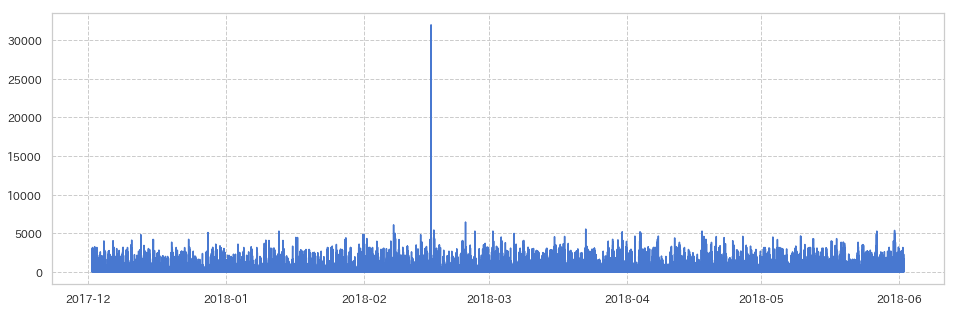

In [18]:
plt.figure(figsize=(16, 5))
plt.plot(train['TransactionDT'], train['TransactionAmt'])

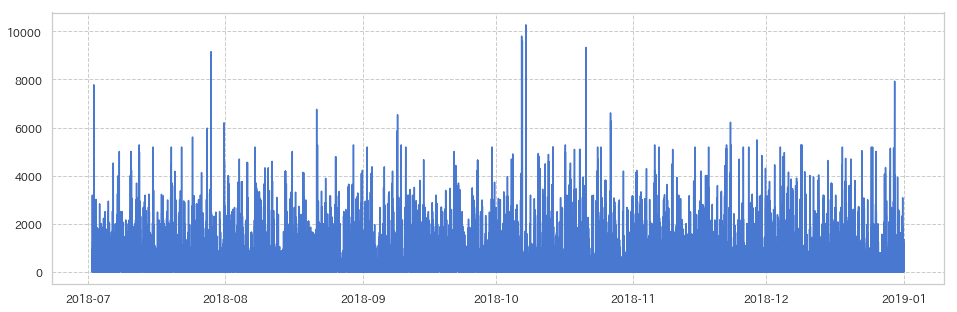

In [24]:
plt.figure(figsize=(16, 5))
plt.plot(test['TransactionDT'], test['TransactionAmt'])

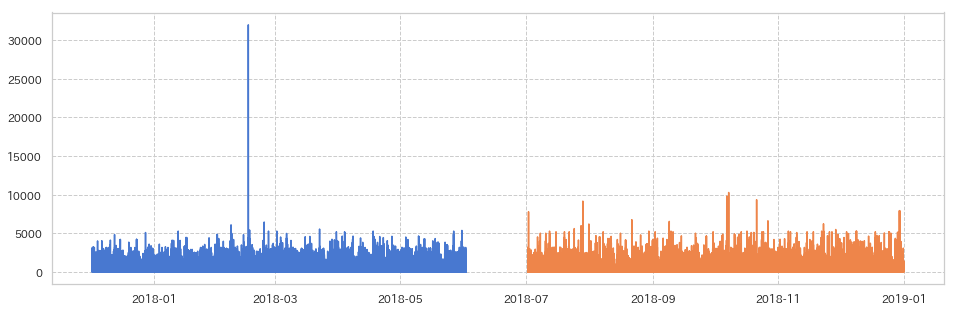

In [25]:
plt.figure(figsize=(16, 5))
plt.plot(train['TransactionDT'], train['TransactionAmt'])
plt.plot(test['TransactionDT'], test['TransactionAmt'])

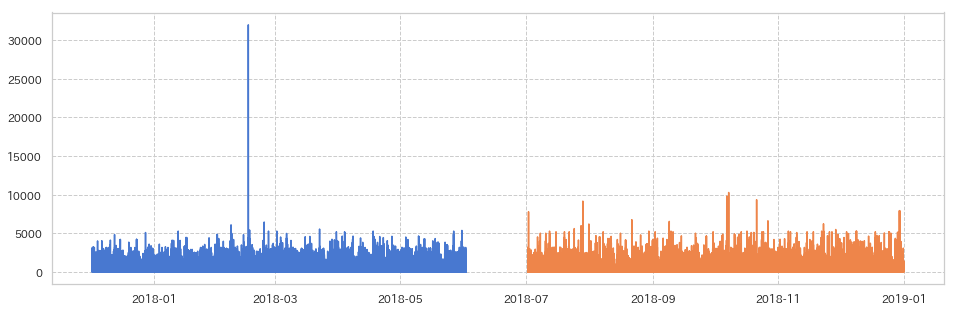

In [25]:
plt.figure(figsize=(16, 5))
plt.plot(train['TransactionDT'], train['TransactionAmt'])
plt.plot(test['TransactionDT'], test['TransactionAmt'])

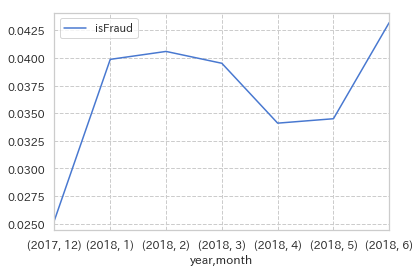

In [22]:
train.groupby(['year', 'month']).agg({'isFraud': 'mean'}).plot()

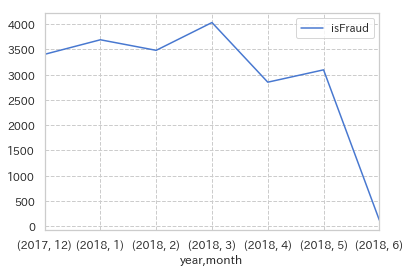

In [26]:
train.groupby(['year', 'month']).agg({'isFraud': 'sum'}).plot()

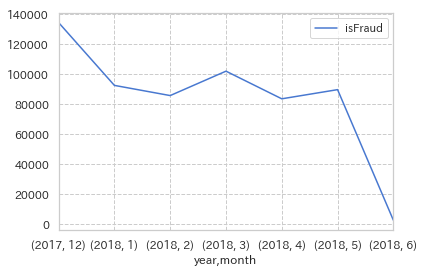

In [23]:
train.groupby(['year', 'month']).agg({'isFraud': 'count'}).plot()

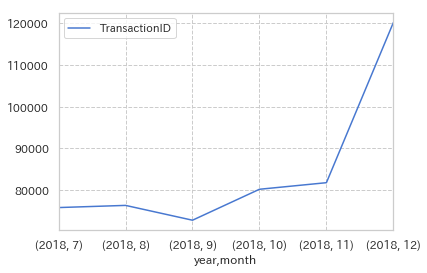

In [27]:
test.groupby(['year', 'month']).agg({'TransactionID': 'count'}).plot()

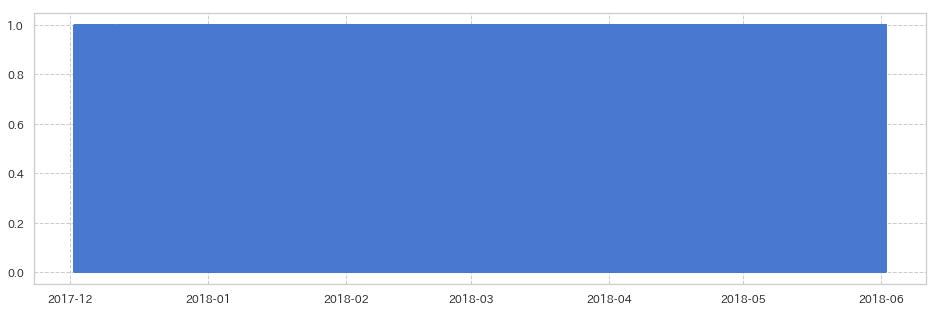

In [19]:
plt.figure(figsize=(16, 5))
plt.plot(train['TransactionDT'], train['isFraud'])

In [13]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,Transaction_day_of_week,Transaction_hour,year,month,dow,quarter,hour,day,all_group_nan_sum,all_group_0_count
0,3663549,2018-07-02 00:00:24,31.950001,W,10409,111.0,150.0,visa,226.0,debit,...,2.0,0.0,2018,7,0,3,0,2,0.480549,0.524229
1,3663550,2018-07-02 00:01:03,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,2.0,0.0,2018,7,0,3,0,2,0.485126,0.475556
2,3663551,2018-07-02 00:01:50,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,2.0,0.0,2018,7,0,3,0,2,0.475973,0.484716
3,3663552,2018-07-02 00:01:50,284.950012,W,10989,360.0,150.0,visa,166.0,debit,...,2.0,0.0,2018,7,0,3,0,2,0.487414,0.455357
4,3663553,2018-07-02 00:01:57,67.949997,W,18018,452.0,150.0,mastercard,117.0,debit,...,2.0,0.0,2018,7,0,3,0,2,0.480549,0.348018


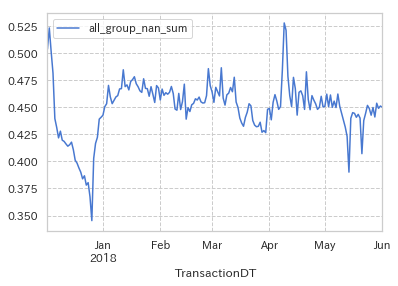

In [34]:
train[['TransactionDT', 'all_group_nan_sum']].set_index('TransactionDT').resample('1d').mean().plot()

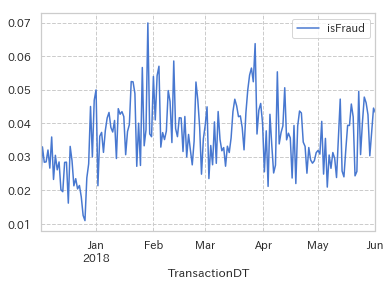

In [50]:
train[['TransactionDT', 'isFraud']].set_index('TransactionDT').resample('1d').mean().plot()

In [54]:
train[['TransactionDT', 'isFraud', 'TransactionAmt']].set_index('TransactionDT').resample('1m').mean()

,isFraud,TransactionAmt
TransactionDT,,
2017-12-31,0.025317,128.279709
2018-01-31,0.039877,133.950607
2018-02-28,0.040595,138.767548
2018-03-31,0.039522,140.420670
2018-04-30,0.034103,133.698914
2018-05-31,0.034503,136.656464
2018-06-30,0.043210,171.459625


In [52]:
train[['TransactionDT', 'isFraud', 'TransactionAmt']].set_index('TransactionDT').resample('1d').mean().corr()

,isFraud,TransactionAmt
isFraud,1.000000,0.084593
TransactionAmt,0.084593,1.000000


In [53]:
train[['TransactionDT', 'isFraud', 'TransactionAmt']].set_index('TransactionDT').resample('1d').sum().corr()

,isFraud,TransactionAmt
isFraud,1.000000,0.395619
TransactionAmt,0.395619,1.000000


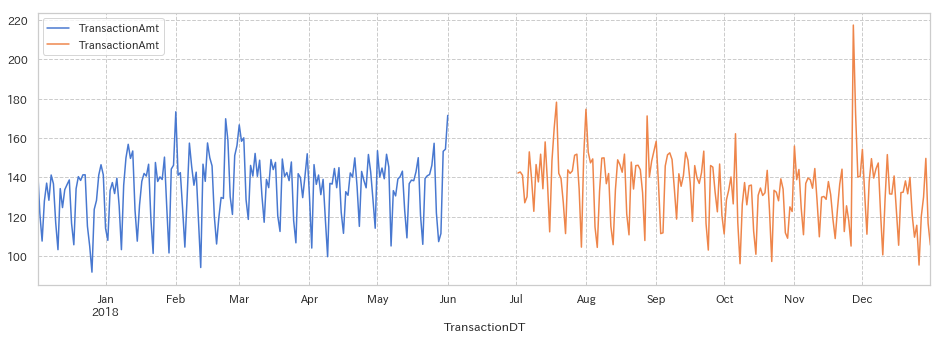

In [49]:
fig, ax = plt.subplots()
ax = train[['TransactionDT', 'TransactionAmt']].set_index('TransactionDT').resample('1d').mean().plot(ax=ax)
test[['TransactionDT', 'TransactionAmt']].set_index('TransactionDT').resample('1d').mean().plot(ax=ax, figsize=(16, 5))

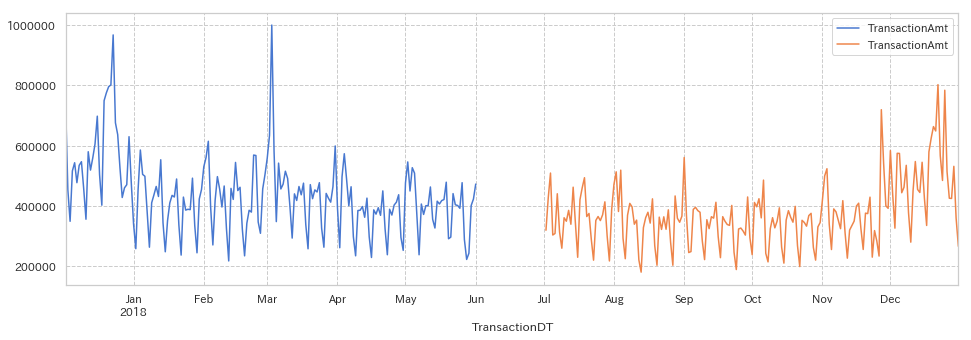

In [48]:
fig, ax = plt.subplots()
ax = train[['TransactionDT', 'TransactionAmt']].set_index('TransactionDT').resample('1d').sum().plot(ax=ax)
test[['TransactionDT', 'TransactionAmt']].set_index('TransactionDT').resample('1d').sum().plot(ax=ax, figsize=(16, 5))

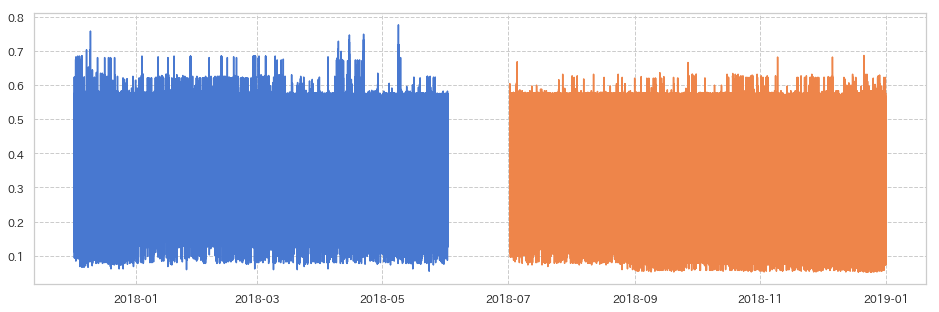

In [30]:
plt.figure(figsize=(16, 5))
plt.plot(train['TransactionDT'], train['all_group_nan_sum'])
plt.plot(test['TransactionDT'], test['all_group_nan_sum'])

In [58]:
train['date_block'] = train['year'] * 100 + train['month']

In [59]:
test['date_block'] = test['year'] * 100 + test['month']

In [66]:
train.groupby('date_block').agg({'TransactionAmt': ['mean', 'sum', 'count']})

TransactionAmt                      
                     mean           sum   count
date_block                                     
201712         128.279709  1.723297e+07  134339
201801         133.950607  1.239177e+07   92510
201802         138.767548  1.189585e+07   85725
201803         140.420670  1.431842e+07  101968
201804         133.698914  1.117335e+07   83571
201805         136.656464  1.225440e+07   89673
201806         171.459625  4.721998e+05    2754

In [67]:
test.groupby('date_block').agg({'TransactionAmt': ['mean', 'sum', 'count']})

TransactionAmt                    
                     mean         sum   count
date_block                                   
201807         141.522980  10717676.0   75731
201808         140.425232  10707705.0   76252
201809         137.853455  10020844.0   72692
201810         127.683777  10230918.0   80127
201811         136.095917  11119989.0   81707
201812         128.697311  15467100.0  120182

In [62]:
corr = train[numeric_feature + ['isFraud']].corr()

In [65]:
corr['isFraud'].sort_values(ascending=False).to_frame()

,isFraud
isFraud,1.000000
V257,0.383060
V246,0.366878
V244,0.364129
V242,0.360590
V201,0.328005
V200,0.318783
V189,0.308219
V188,0.303582
V258,0.297151


In [73]:
train['tmp'] = 0

In [71]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,Transaction_hour,year,month,dow,quarter,hour,day,all_group_nan_sum,all_group_0_count,date_block
0,2987000,0,2017-12-02 00:00:00,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,2017,12,5,4,0,2,0.534247,0.524510,201712
1,2987001,0,2017-12-02 00:00:01,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,2017,12,5,4,0,2,0.525114,0.634615,201712
2,2987002,0,2017-12-02 00:01:09,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,2017,12,5,4,0,2,0.481735,0.546256,201712
3,2987003,0,2017-12-02 00:01:39,50.0,W,18132,567.0,150.0,mastercard,117.0,...,0.0,2017,12,5,4,0,2,0.518265,0.436019,201712
4,2987004,0,2017-12-02 00:01:46,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,2017,12,5,4,0,2,0.312785,0.568106,201712


In [70]:
train[['year', 'date_block']].add_prefix('PREF__', inplace)

,PREF__year,PREF__date_block
0,2017,201712
1,2017,201712
2,2017,201712
3,2017,201712
4,2017,201712
5,2017,201712
6,2017,201712
7,2017,201712
8,2017,201712
9,2017,201712


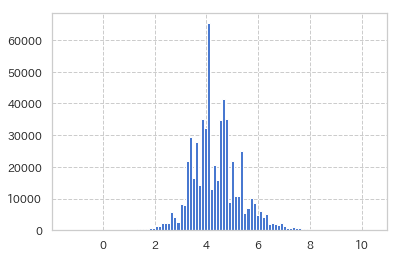

In [86]:
plt.hist(np.log(train['TransactionAmt']), bins=100);

In [103]:
train['TransactionDT'].max()

Timestamp('2018-06-01 23:58:51')